# Ecological Data Science for Sustainable Agriculture (Part III)

## Introduction

## Imports

In [2]:
# Vector processing
import geopandas as gpd
import shapely
import osgb

# Raster processing
import rasterio
import rasterio.warp
import rasterio.mask
import rasterio.plot
import rasterio.features
import rasterio.sample
from rasterio import windows
import pyproj
import xarray as xr
import rioxarray

# Calcs and modelling
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import contextily as cx
import seaborn as sns

%matplotlib inline
mpl.rcParams['axes.formatter.limits'] = (0,0)
FIGSIZE = (10, 7)

# Practical
from glob import glob
import warnings
import os
from pystac_client import Client
import boto3
from dask.distributed import Client as DaskClient
from dask.distributed import print as distributed_print
import subprocess
import functools
import sys
sys.path.append('../../../../git_packages/PhenoloPy/scripts')
import phenolopy
from scipy.stats import pearsonr

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

DATA_BASE_PATH = '../../../data/Agric_data/NPMS_Locations/' # all data under this path (global)
WORKING_CRS = 'EPSG:3035'


## Methods

### Biodiversity data: UK National Plant Monitoring Scheme



Drop data for locations where sensitive species were found (for these, geolocation data was spatially blurred by the PMS). This corresponds to less than 1% of the dataset.

Note that some of the post-processing of biodiversity data is done in the results section, per AOI site (more efficient than calculating metrics on the entire sample here).

In [10]:
occurrences = pd.read_csv('../../../data/Agric_data/Plant/data/occurrences_2015to2022.csv').set_index('id')

# Drop spatially blurred observations
occurrences = occurrences[occurrences['sensitivity_precision'].isna()].drop(columns=['sensitivity_precision','record_status'])

occurrences.head()

,sample_id,taxonversionkey,preferred_taxon,domin
id,,,,
1897182,888635,NBNSYS0000002205,Allium ursinum,4. 5-10%
1897183,888635,NBNSYS0000004319,Galium aparine,2. < 1% (several indivs)
1897184,888635,NBNSYS0000004239,Lamium galeobdolon,1. < 1% (1-2 indivs)
1897185,888635,NBNSYS0000002185,Hyacinthoides non-scripta,4. 5-10%
1897189,888639,NBNSYS0000002185,Hyacinthoides non-scripta,4. 5-10%


In [11]:
locations = pd.read_csv('../../../data/Agric_data/Plant/data/locations_2015to2022.csv').set_index('location_id')
locations.head()

,location_type,samplecount
location_id,,
41159,Linear plot,2
41160,Linear plot,2
41163,"Square plot 5 x 5 m, most habitats",2
41164,"Square plot 5 x 5 m, most habitats",2
41165,"Square plot 5 x 5 m, most habitats",2


In [12]:
_temp = pd.read_csv('../../../data/Agric_data/Plant/data/sampleinfowithlatlong_2015to2022.csv', 
                    index_col=0,
                   dtype={'location_id':'Int64'})
sample_info = gpd.GeoDataFrame(_temp,
                                geometry=gpd.GeoSeries.from_xy(_temp['LONGITUDE'],
                                                              _temp['LATITUDE']),
                               crs='EPSG:4326').set_index('id')
sample_info = sample_info.to_crs(WORKING_CRS)
sample_info['date_start'] = pd.to_datetime(sample_info['date_start'])
sample_info['year'] = sample_info['date_start'].dt.year

# Define study regions for data download later
buffer_radius = 100
sample_info['study_zone'] = sample_info.geometry.buffer(buffer_radius)
sample_info['study_zone_bbox'] = shapely.box(*np.split(sample_info['study_zone'].bounds.values, 4, axis=1)).flatten()

sample_info.head()

,survey_id,date_start,location_id,entered_sref,entered_sref_system,created_on,created_by_id,LATITUDE,LONGITUDE,monad,monadCRS,country,geometry,year,study_zone,study_zone_bbox
id,,,,,,,,,,,,,,,,
19727875,87,2021-07-09,222035,H0851653089,OSIE,2022-07-29 17:29:37,169848,54.426207,-7.868770,H0853,OSIE,Northern_Ireland,POINT (3174650.927 3622819.751),2021,"POLYGON ((3174750.927 3622819.751, 3174750.446...",POLYGON ((3174750.9274035688 3622719.751499645...
19726403,87,2021-07-09,222034,H0863353204,OSIE,2022-07-29 16:44:06,169848,54.427238,-7.866964,H0853,OSIE,Northern_Ireland,POINT (3174792.690 3622902.677),2021,"POLYGON ((3174892.690 3622902.677, 3174892.208...",POLYGON ((3174892.6895344253 3622802.676799679...
6973078,87,2019-09-16,222035,H0851653089,OSIE,2019-10-29 14:56:26,169848,54.426207,-7.868770,H0853,OSIE,Northern_Ireland,POINT (3174650.927 3622819.751),2019,"POLYGON ((3174750.927 3622819.751, 3174750.446...",POLYGON ((3174750.9274035688 3622719.751499645...
6959657,87,2019-08-26,221971,J3583127831,OSIE,2019-10-26 21:33:38,228514,54.181371,-5.919232,J3527,OSIE,Northern_Ireland,POINT (3291134.303 3566771.327),2019,"POLYGON ((3291234.303 3566771.327, 3291233.821...",POLYGON ((3291234.302572135 3566671.3274340653...
6958813,87,2019-08-26,221939,J3533127831,OSIE,2019-10-26 14:11:05,228514,54.181503,-5.926886,J3527,OSIE,Northern_Ireland,POINT (3290651.791 3566895.061),2019,"POLYGON ((3290751.791 3566895.061, 3290751.310...",POLYGON ((3290751.7913411325 3566795.060770185...


In [13]:
sample_attributes = pd.read_csv('../../../data/Agric_data/Plant/data/sampleattributes_2015to2022.csv').set_index('sample_attribute_id')
sample_attributes.head()

,sample_id,caption,text_value
sample_attribute_id,,,
3211938,884186,NPMS Survey 1 ID,0
3211939,884186,NPMS Habitat,Neutral pastures and meadows
3211940,884186,Management,Cutting / mowing
3211941,884186,Other Management,mown for recretion
3211942,884186,NPMS Grazers,none


Now let's take only the sampling locations by arable fields:

In [14]:
arable_samples = sample_attributes[(sample_attributes['caption'] == 'NPMS Habitat') & sample_attributes['text_value'].isin(['Arable field margins', 'Arable margins'])]
arable_samples.head()

,sample_id,caption,text_value
sample_attribute_id,,,
3376134,928802,NPMS Habitat,Arable field margins
3384293,931623,NPMS Habitat,Arable field margins
3384984,931906,NPMS Habitat,Arable field margins
3386744,932789,NPMS Habitat,Arable field margins
3412398,951869,NPMS Habitat,Arable field margins


And look up those samples, cleaning for duplicate geometry / date combinations

In [15]:
arable_samples_loc_yr_unique = sample_info.loc[arable_samples['sample_id'].unique()][['geometry', 'year', 'date_start', 'study_zone', 'study_zone_bbox', 'survey_id']].drop_duplicates(subset=['geometry', 'date_start'])
arable_samples_loc_yr_unique = arable_samples_loc_yr_unique[(arable_samples_loc_yr_unique['year'] <= 2020) & (arable_samples_loc_yr_unique['year'] >= 2018)]
arable_samples_loc_yr_unique.head()

,geometry,year,date_start,study_zone,study_zone_bbox,survey_id
id,,,,,,
2459716,POINT (3347328.898 3112656.417),2018,2018-05-18,"POLYGON ((3347428.898 3112656.417, 3347428.417...",POLYGON ((3347428.8984529204 3112556.417126075...,87
3374584,POINT (3613310.248 3353483.205),2018,2018-04-01,"POLYGON ((3613410.248 3353483.205, 3613409.767...",POLYGON ((3613410.2482128586 3353383.205378609...,155
3425299,POINT (3587828.892 3171514.315),2018,2018-04-22,"POLYGON ((3587928.892 3171514.315, 3587928.410...",POLYGON ((3587928.8916301527 3171414.315482463...,154
3432713,POINT (3509784.399 3428080.153),2018,2018-04-23,"POLYGON ((3509884.399 3428080.153, 3509883.918...","POLYGON ((3509884.399378102 3427980.153094661,...",154
3440706,POINT (3436618.076 2977607.276),2018,2018-04-29,"POLYGON ((3436718.076 2977607.276, 3436717.594...","POLYGON ((3436718.075516487 2977507.276026127,...",154


### Agricultural land use data

The CROME data for each of these locations is downloaded outside of this script (HOW). Hexagons have an area of around 0.4 hectares and a side length of around 40 metres.

To capture agricultural intensity effects and to maintain fidelity to the process presented in [CITE PAPER], quite a strict constraint on the proximity of spring cereals is used here. 

Locations have already been filtered for those noted "arable (field) margins" by PMS volunteers, and here are further filtered for those surrounded by spring cereals in the year corresponding to the PMS data. Specifically, I require a minimum of three CROME cells labelled "spring cereal" intersecting a 100 metre radius of the PMS sampling location.

In [16]:
SPRING_CEREAL_LUCODES = ['AC01', # barley
                         'AC19', # oats
                         'AC24', # rye
                         'AC30', # triticale
                         'AC32'] # wheat


In [18]:
sc_aoi_dirs = [] # correspond to PMS sample IDs
for i, location_path in enumerate(glob(os.path.join(DATA_BASE_PATH, '*', 'CROME'))):
    crome_data = gpd.read_file(location_path).to_crs(arable_samples_loc_yr_unique.crs)
    
    # filter for spring cereals
    crome_data = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)]
    
    aoi_dir = location_path.split('/')[-2]
    id = int(aoi_dir.split('_')[1])
    
    sc_cells_in_radius = crome_data[crome_data.intersects(arable_samples_loc_yr_unique.loc[id, 'study_zone'])]
    
    if len(sc_cells_in_radius) >= 3:
        sc_aoi_dirs.append(aoi_dir)

Plot an example of a location where spring cereals were grown in the year, with the CROME data (SC only) and study zone overlaid:

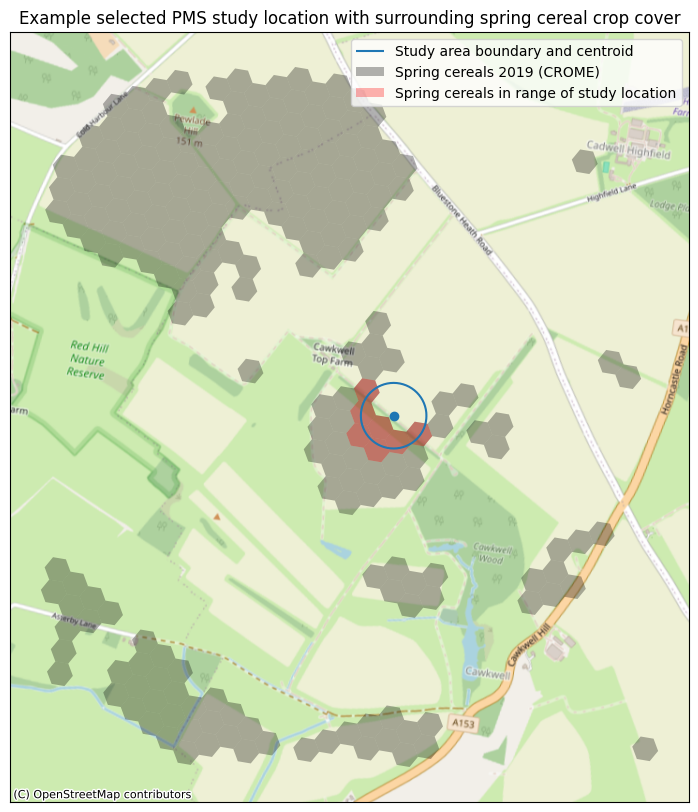

In [68]:
# Select example datapoint
dir = sc_aoi_dirs[0]
id = int(dir.split('_')[1])
location_path = f'../../../data/Agric_data/NPMS_Locations/{dir}/CROME'
crome_data = gpd.read_file(location_path).to_crs(arable_samples_loc_yr_unique.crs)
    
# filter for spring cereals
crome_data = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)]
sc_cells_in_radius = crome_data[crome_data.intersects(arable_samples_loc_yr_unique.loc[id, 'study_zone'])]

# Plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
crome_data.plot(ax=ax, color='k', alpha=0.3, edgecolor=None)
cx.add_basemap(ax, crs=arable_samples_loc_yr_unique.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=15)

arable_samples_loc_yr_unique.loc[[id]].plot(ax=ax)
arable_samples_loc_yr_unique.loc[[id]]['study_zone'].exterior.plot(ax=ax, label='Study area boundary and centroid')
sc_cells_in_radius.plot(ax=ax, color='red', alpha=0.3, label='Spring cereals in range of study location')



legend_handles = [mpl.patches.Patch(facecolor='k', alpha=0.3, label=f"Spring cereals {location_path.split('/')[-2].split('_')[-1]} (CROME)"),
                  mpl.patches.Patch(facecolor='r', alpha=0.3, label="Spring cereals in range of study location")]

plt.legend(handles=ax.get_legend_handles_labels()[0] +  legend_handles)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Example selected PMS study location with surrounding spring cereal crop cover')
plt.show()



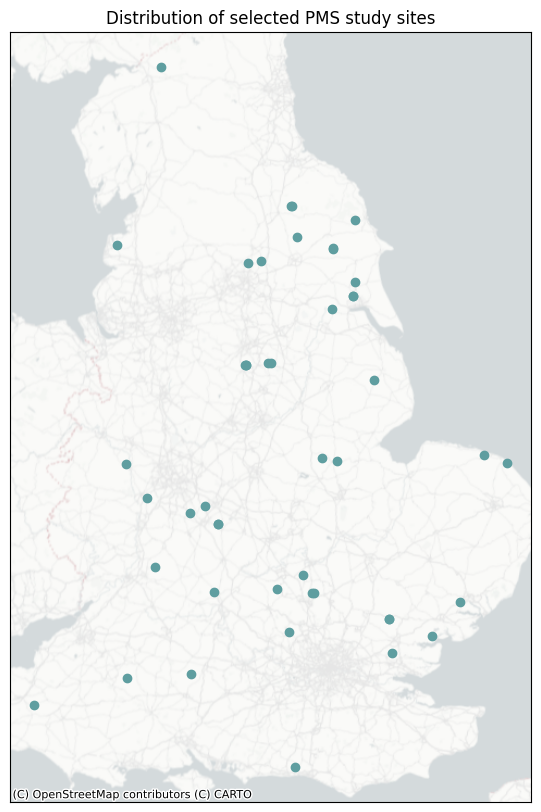

In [75]:
ax = arable_samples_loc_yr_unique.loc[[int(i.split('_')[1]) for i in sc_aoi_dirs]].drop_duplicates('geometry').plot(figsize=(10, 10), edgecolor=None, color='cadetblue')
cx.add_basemap(ax, crs=arable_samples_loc_yr_unique.crs, source=cx.providers.CartoDB.PositronNoLabels)
ax.set_xticks([])
ax.set_yticks([])
plt.title('Distribution of selected PMS study sites')
plt.show()

### Satellite imagery

In [13]:
def get_pystack_aws_sessions():
    '''Initiates a pystac client and rasterio AWS session to coordinate requests.'''
    
    # Instantiate a stac client to download the images
    client = Client.open("https://earth-search.aws.element84.com/v1")
    
    # Instantiate an AWS session to download S2 imagery
    aws_session = rasterio.session.AWSSession(boto3.Session(), requester_pays=True)

    return client, aws_session

client, aws_session = get_pystack_aws_sessions()

In [14]:
def read_S3(href, aoi_bbox_geodetic):
    '''Downloads the data and metadata corresponding to an acquisition, based on a 
    reference and spatial filter (defined as a shapely bbox in EPSG:4326).'''
    with rasterio.open(href) as src:
        # Transform window to src crs
        transform_geodetic_to_s2 = pyproj.Transformer.from_crs("EPSG:4326", src.crs, always_xy=True).transform
        src_bbox = shapely.ops.transform(transform_geodetic_to_s2, aoi_bbox_geodetic)
        window = rasterio.windows.from_bounds(*conform_bbox(src_bbox),
                                              transform=src.transform).round_lengths()
        data = src.read(window=window) 
        src_profile = src.profile
        
        src_profile.update({'width': window.width,
                            'height': window.height,
                            'transform': rasterio.windows.transform(window, src.transform)})

    return {'data': data, 'profile': src_profile}
    
def get_geodetic_bbox(bbox, bbox_crs):
    '''Transforms a bounding box (as a shapely box) in a given CRS to EPSG:4326'''
    # Get transformer for bbox
    transform_working_to_geodetic = pyproj.Transformer.from_crs(pyproj.CRS(bbox_crs), 
                                                                pyproj.CRS('EPSG:4326'), 
                                                                always_xy=True).transform
    # Get transformed bbox (in EPSG:4326)
    bbox_geodetic_coords = transform_working_to_geodetic(*bbox.exterior.xy)
    bbox_geodetic = shapely.geometry.Polygon(np.stack(bbox_geodetic_coords, axis=1))

    return bbox_geodetic

def conform_bbox(shapely_bbox):
    '''Returns coords as left, bottom, right, top from a shapely box.
    
    This is a utility function to go between shapely and (rasterio and pystac)'''
    shapely_bbox_coords = shapely_bbox.exterior.coords.xy
    rio_stac_bbox_coords = [min(shapely_bbox_coords[0]), # Align shapely and pystac conventions
                             min(shapely_bbox_coords[1]), 
                             max(shapely_bbox_coords[0]), 
                             max(shapely_bbox_coords[1])]
            
    return rio_stac_bbox_coords
    
def search_stac(client, aoi_bbox_geodetic=None, datetime=None, max_items=1000, query=None):
    '''searchs a stac collection with using client, filtering based on aoi_bbox_geodetic
    (a shapely box in EPSG:4326), and based on datetime. See pystac docs for client.search 
    API details.

    Note that pystac client expands datetimes, i.e. from the docs "2017 
    expands to 2017-01-01T00:00:00Z/2017-12-31T23:59:59Z".
    
    query examples:
      filter on processing baseline (see https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/processing-baseline)
        query = {'s2:processing_baseline': {"neq": "05.00"}}

      filter on cloud cloverage
        query=['eo:cloud_cover<50']
    '''
    
    search = client.search(max_items=max_items, # speed up
                           collections=['sentinel-2-l2a'],
                           query=query,
                           bbox=conform_bbox(aoi_bbox_geodetic),
                           datetime=datetime)

    if search.matched() == max_items:
        print('Did not receive complete results. Consider increasing max_items kwarg ' + \
          f'(currently {max_items}).')

    return search


def item_covers_aoi(stac_item, aoi_geodetic):
    '''Returns true/false depending on whether the acquisition geometry fully covers the
    AOI.'''
    
    return shapely.geometry.shape(stac_item.geometry).contains(aoi_geodetic)

# Filter on clouds
def pass_clouds_snow(scl_data, max_cloud_perc=None):
    '''Returns true/false depending on whether the area proportion of the acquisition which
    is cloudy (according to the S2 cloud detection algorithm) is less than max_cloud_perc.
    
    Also includes snow/ice (SCL code 11).'''
    
    medium_cloud_prob = np.sum(scl_data == 8)
    high_cloud_prob = np.sum(scl_data == 9)
    snow_ice = np.sum(scl_data == 11)

    return (100 * ((medium_cloud_prob + high_cloud_prob + snow_ice) / np.size(scl_data))) < max_cloud_perc

def clean_dir(path):
    '''Clears up directories if download is re-run.'''
    files = os.listdir(path)
    if len(files) > 0:
        for file in files:
            distributed_print(f'### Cleaning (removing) {file}')
            os.remove(os.path.join(path, file))


def calculate_evi2(nir_data, red_data, profile):
    '''Returns the vegetation index EVI2 and corresponding raster profile.'''
    QUANT_VAL = 10000
    # Calculate evi2
    evi2 = 2.5 * ((nir_data / QUANT_VAL).astype(np.float32) - (red_data / QUANT_VAL).astype(np.float32)) / ((nir_data / QUANT_VAL).astype(np.float32) + 2.4*(red_data / QUANT_VAL).astype(np.float32) + 1)
    evi2_profile = {**profile, **{'nodata':np.nan, 'dtype': 'float32'}}

    return {'data': evi2, 'profile': evi2_profile}

def get_reprojected_profile(src_profile, target_crs, target_width=None, target_height=None, target_res=None):
    '''Calculates necessary changes to an arbritary source profile (a dictionary
    based on a rasterio read) to write to a target CRS or target width, height.'''
    
    transformer = rasterio.transform.AffineTransformer(src_profile['transform']) 
    left, top = transformer.xy(0,0, offset='ul')
    right, bottom = transformer.xy(src_profile['height'], src_profile['width'], offset='ul')
    
    # Get default transform
    transform, width, height = rasterio.warp.calculate_default_transform(src_profile['crs'], 
                                                                            target_crs, 
                                                                            src_profile['width'], 
                                                                            src_profile['height'], 
                                                                            left=left,
                                                                            bottom=bottom,
                                                                            right=right,
                                                                            top=top,
                                                                            dst_width=target_width,
                                                                            dst_height=target_height,
                                                                            dst_resolution=target_res)

    # Update profile with new crs, transform and dimensions
    transform, width, height = rasterio.warp.aligned_target(transform, width, height, target_res)
    new_profile = {k:v for k, v in src_profile.items()}
    new_profile.update({'crs': target_crs,
                        'transform': transform,
                        'width': width,
                        'height': height})

    return new_profile
    
def trim_raster(to_trim_path, geometry):
    '''Overwrites to_trim_path, trimming to (shapely) geometry defined in same CRS as raster.'''
    
    with rasterio.open(to_trim_path) as src:
        data, masked_transform = rasterio.mask.mask(src, [geometry], crop=True, all_touched=True)
        profile = src.profile
        
    profile.update({"height": data.shape[1],
                    "width": data.shape[2],
                    "transform": masked_transform})

    with rasterio.open(to_trim_path, "w", **profile) as dest:
        dest.write(data)
        
def reproject_clip_write(data, source_profile, target_profile, full_write_path, aoi_geometry):
    '''Reprojects S2 data to working CRS and writes to disk, clipping to AOI geometry.'''
    target_profile.update({'nodata': source_profile['nodata'], 'dtype': source_profile['dtype'], 'count': source_profile['count']})
    with rasterio.open(full_write_path, 'w', **target_profile) as dst:
        for i in range(1, target_profile['count'] + 1):
            rasterio.warp.reproject(source=data,
                                    destination=rasterio.band(dst, i),
                                    src_transform=source_profile['transform'],
                                    src_crs=source_profile['crs'],
                                    resampling=rasterio.warp.Resampling.nearest)

    trim_raster(full_write_path, aoi_geometry)
    


In [34]:
band_names = ['red', 'nir', 'visual']

MAX_ITEMS = 1000
max_cloud_perc = 10

def handle_download_errors(_download_items):
    def log_and_skip_errors(_dir_name):
        try:
            return _download_items(_dir_name)
        except Exception as e:
            distributed_print(f'Location: {_dir_name} :: ERROR (skipping) ' + str(e))
            return None

    return log_and_skip_errors
    
@handle_download_errors
def download_items(dir_name):
    '''Downloads all S2 data for a given download directory of structure: location_{PMS sample ID}_{PMS sample year}.'''
    sample_id = int(dir_name.split('_')[1])
    sample_year = dir_name.split('_')[2]
    data_path =  f'../../../data/Agric_data/NPMS_Locations/{dir_name}/'    
    distributed_print(f'Sample ID: {sample_id}, sample year: {sample_year} :: Starting processing')

    # Skip this location if it was already processed
    if os.path.exists(os.path.join(data_path, 'metadata.csv')):
        distributed_print(f'Location: {dir_name} :: Already processed, skipping')
        return None
        
    # Get search results
    true_aoi_bbox = arable_samples_loc_yr_unique.loc[sample_id]['study_zone_bbox'] # in projected coords
    # buffer this by a pixel so that there are no missing corners in the data download (this can happen because of reprojections and finite resolution imagery)
    aoi_bbox = true_aoi_bbox.buffer(10, join_style=2)
    aoi_bbox_geodetic = get_geodetic_bbox(aoi_bbox, arable_samples_loc_yr_unique.crs) # in EPSG:4326
    search_results = search_stac(client, aoi_bbox_geodetic=aoi_bbox_geodetic, datetime=sample_year, 
                                 max_items=MAX_ITEMS, query={'s2:processing_baseline': {"neq": "05.00"}}) # Sentinel 2 reprocessing has not completed for 2019

    # Now iterate through dates with S2 acquisitions and download if they're good enough (intersect PoMS location fully and not too many clouds)
    for item in search_results.items():
        # Store date reference
        date_ref = item.datetime.strftime('%Y_%m_%d')
        base_write_path = os.path.join(data_path, date_ref)
        distributed_print(f'Sample ID: {sample_id}, sample year: {sample_year}, date: {date_ref} :: Starting acquisition processing')
        
        # If there is already a folder here and it contains the right number of files, consider this date to be processed and skip
        if os.path.exists(base_write_path) and (len(os.listdir(base_write_path)) == (len(band_names) + 2)):
            distributed_print(f'Sample ID: {sample_id}, sample year: {sample_year}, date: {date_ref} :: Already have correct number of files, skipping')
            continue

        # Require full coverage of the AOI
        if not item_covers_aoi(item, aoi_bbox_geodetic):
            continue
            
        # Next a cloud check
        s2_thematic = read_S3(item.assets['scl'].href, aoi_bbox_geodetic)
        if not pass_clouds_snow(s2_thematic['data'], max_cloud_perc=max_cloud_perc):
            distributed_print(f'Sample ID: {sample_id}, sample year: {sample_year}, date: {date_ref} :: Too cloudy/snowy, skipping (more than {max_cloud_perc}% of image medium or high cloud probability or snow/ice)')
            continue

        # At this point we'll download the imagery, so create write directory if it does not already exist
        if not os.path.exists(base_write_path):
            os.mkdir(base_write_path)
        else:
            clean_dir(base_write_path)
            
        # Read data from S3 - already calculated scl so just add that to the dictionary instead of redownloading
        band_data = {band_name: read_S3(item.assets[band_name].href, aoi_bbox_geodetic) for band_name in band_names}
        band_data['scl'] = s2_thematic
        band_data['evi2'] = calculate_evi2(band_data['nir']['data'], # Vegetation index
                                           band_data['red']['data'],
                                           band_data['nir']['profile'].copy())

        # Define a target profile, which each raster will be aligned with
        target_height, target_width = (band_data['red']['profile'][i] for i in ['height', 'width'])
        target_res = (-band_data['red']['profile']['transform'][4], band_data['red']['profile']['transform'][0])
        target_profile = get_reprojected_profile(band_data['red']['profile'], WORKING_CRS, target_width=target_width, 
                                                 target_height=target_height, target_res=target_res)
        
        # Write results, reprojecting everything into WORKING_CRS and trimming to the AOI bbox
        for band_name, data_profile in band_data.items():
            full_write_path = os.path.join(base_write_path, band_name + '.tif')
            reproject_clip_write(data_profile['data'], data_profile['profile'], target_profile, full_write_path, true_aoi_bbox) # clip to true aoi bbox
            distributed_print(f'Sample ID: {sample_id}, sample year: {sample_year}, date: {date_ref}, band: {band_name} :: Written to {full_write_path}')
            
    # Now create a file to hold any metadata we may want to add and also signals completion of this location's download            
    subprocess.run(['touch', os.path.join(data_path, 'metadata.csv')])
    
    return None

with rasterio.Env(aws_session):
    dask_client = DaskClient(threads_per_worker=4, n_workers=2)
    futures = []
    for dir in sc_aoi_dirs:
        future = dask_client.submit(download_items, dir)
        futures.append(future)
    
    dask_client.gather(futures)


Sample ID: 6276882, sample year: 2019 :: Starting processing
Location: location_6276882_2019 :: Already processed, skipping
Sample ID: 8148381, sample year: 2020 :: Starting processing
Location: location_8148381_2020 :: Already processed, skipping
Sample ID: 10530878, sample year: 2020 :: Starting processing
Location: location_10530878_2020 :: Already processed, skipping
Sample ID: 3536063, sample year: 2018 :: Starting processing
Sample ID: 14727289, sample year: 2020 :: Starting processing
Location: location_14727289_2020 :: Already processed, skipping
Sample ID: 3536063, sample year: 2018, date: 2018_12_31 :: Starting acquisition processing
Sample ID: 3536063, sample year: 2018, date: 2018_12_31 :: Already have correct number of files, skipping
Sample ID: 3536063, sample year: 2018, date: 2018_12_31 :: Starting acquisition processing
Sample ID: 3536063, sample year: 2018, date: 2018_12_31 :: Already have correct number of files, skipping
Sample ID: 3536063, sample year: 2018, date: 

Let's take a look at the contents of one download directory:

In [84]:
# Select an AOI with data
hit_dirs = [i for i in os.listdir(DATA_BASE_PATH) if os.path.isdir(os.path.join(DATA_BASE_PATH, i)) and ('metadata.csv' in os.listdir(os.path.join(DATA_BASE_PATH, i)))]
hit_dir = hit_dirs[3]

# Select one date's data for that AOI
hit_dates = os.listdir(os.path.join(DATA_BASE_PATH, hit_dir))
hit_date = hit_dates[5]

# Construct full path
aoi_date_download_path = os.path.join(DATA_BASE_PATH, hit_dir, hit_date)

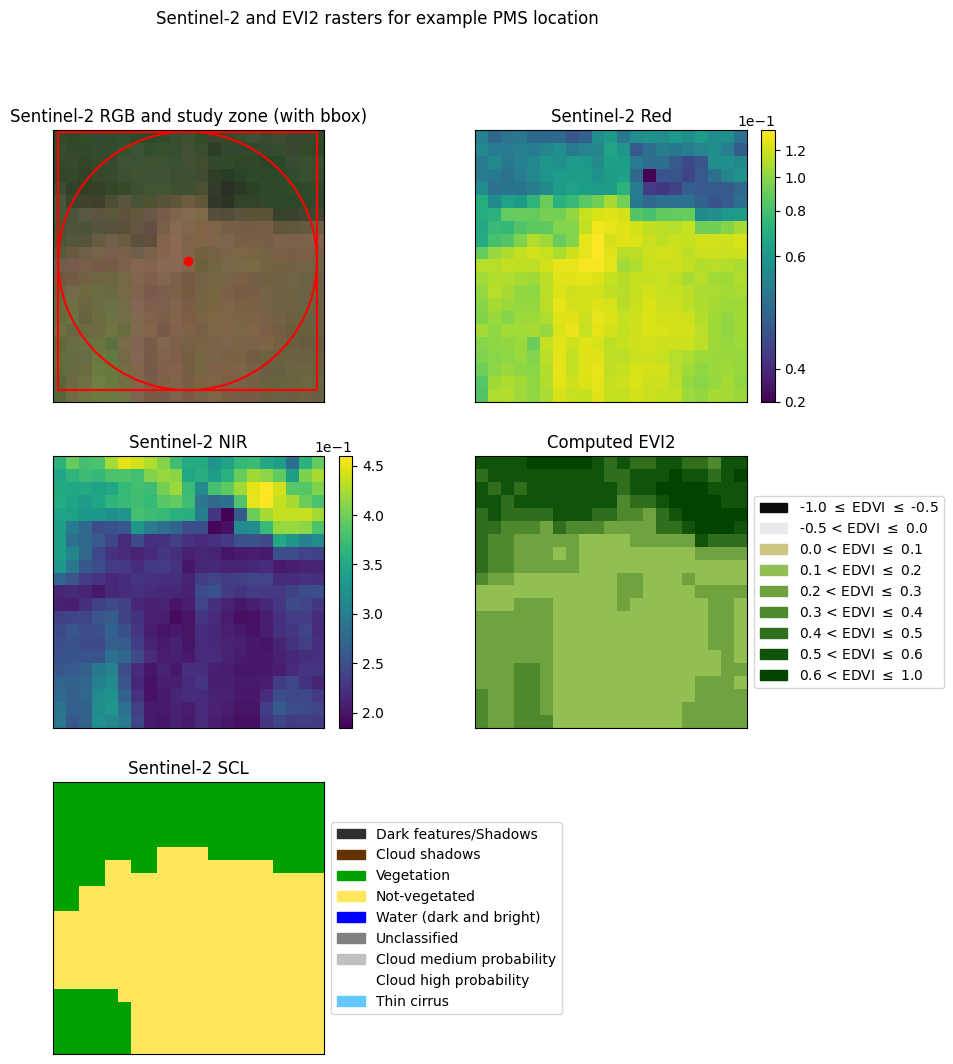

In [90]:




id = int(hit_dir.split('_')[1])


# Colormap as defined at https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/
edvi_ranges = ['-1.0 $\leq$ EDVI $\leq$ -0.5',
               '-0.5 < EDVI $\leq$ 0.0',
               '0.0 < EDVI $\leq$ 0.1',
               '0.1 < EDVI $\leq$ 0.2',
               '0.2 < EDVI $\leq$ 0.3',
               '0.3 < EDVI $\leq$ 0.4',
               '0.4 < EDVI $\leq$ 0.5',
               '0.5 < EDVI $\leq$ 0.6',
               '0.6 < EDVI $\leq$ 1.0'
              ]

edvi_ranges_nums =  [-1.0, -0.5, 0.0,
                                    0.1,
                                    0.2,
                                    0.3,
                                    0.4,
                                    0.5,
                                    0.6,
                                    1.0]
edvi_colors = [[i/255 for i in [12, 12, 12]],
                        [i/255 for i in [234, 234, 234]],
                        [i/255 for i in [204, 198, 130]],
                        [i/255 for i in [145, 191, 81]],
                        [i/255 for i in [112, 163, 63]],
                        [i/255 for i in [79, 137, 45]],
                        [i/255 for i in [48, 109, 28]],
                        [i/255 for i in [15, 84, 10]],
                        [i/255 for i in [0, 68, 0]]]


# Color mapping for the scene classification
# Color map as described at https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

classification_names = ['Dark features/Shadows',
                        'Cloud shadows',
                        'Vegetation',
                        'Not-vegetated',
                        'Water (dark and bright)',
                        'Unclassified',
                        'Cloud medium probability',
                        'Cloud high probability',
                        'Thin cirrus']

classification_colors = [[i/255 for i in [47, 47, 47]],
                        [i/255 for i in [100, 50, 0]],
                        [i/255 for i in [0, 160, 0]],
                        [i/255 for i in [255, 230, 90]],
                        [i/255 for i in [0, 0, 255]],
                        [i/255 for i in [128, 128, 128]],
                        [i/255 for i in [192, 192, 192]],
                        [i/255 for i in [255, 255, 255]],
                        [i/255 for i in [100, 200, 255]]]

scl_cmap = mpl.colors.LinearSegmentedColormap.from_list('SCL map', classification_colors, len(classification_colors))
scl_thematic_map = [mpl.patches.Patch(color=color, label=label) for color, label in zip(classification_colors, 
                                                                                        classification_names)]
scl_norm = mpl.colors.BoundaryNorm([i - 0.5 for i in range(2, 12)], scl_cmap.N)



edvi_cmap = mpl.colors.LinearSegmentedColormap.from_list('EDVI map', edvi_colors, len(edvi_colors))
edvi_thematic_map = [mpl.patches.Patch(color=color, label=label) for color, label in zip(edvi_colors, edvi_ranges)]
edvi_norm = mpl.colors.BoundaryNorm(edvi_ranges_nums, edvi_cmap.N)


fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(10, 12))
axs = axs.ravel()

views = ['visual', 'red', 'nir', 'evi2', 'scl']
titles = ['Sentinel-2 RGB and study zone (with bbox)', 'Sentinel-2 Red', 'Sentinel-2 NIR', 'Computed EVI2', 'Sentinel-2 SCL']
norms = [None, mpl.colors.PowerNorm(0.4), None, edvi_norm, scl_norm]
cmaps = [None, None, None, edvi_cmap, scl_cmap]

for i, view in enumerate(views):
    band_name = view
    with rasterio.open(os.path.join(aoi_date_download_path, view + '.tif')) as src:
        data_profile = {'data': src.read(), 'profile': src.profile}
        extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    
    ax = axs[i]
    if view in ['red', 'nir']:
        plot_data = data_profile['data'] / 10000 # Quantification value
    else:
        plot_data = data_profile['data']
        
    im = ax.imshow(np.squeeze(np.moveaxis(plot_data, 0, -1)), 
                   norm=norms[i],
                   cmap=cmaps[i], 
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                   extent=extent
                  )

    if view == 'visual':
        arable_samples_loc_yr_unique.loc[[id]].plot(ax=ax, color='red', label='PMS study area centroid')
        arable_samples_loc_yr_unique.loc[[id]]['study_zone'].exterior.plot(ax=ax, label='study zone', 
                                                               color='red')
        arable_samples_loc_yr_unique.loc[[id]].set_geometry('study_zone_bbox')['study_zone_bbox'].exterior.plot(ax=ax, label='study zone bbox', 
                                                               color='red')
        
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], wrap=True)
    cbar = fig.colorbar(im, label=None, fraction=0.046, pad=0.04)
    if view == 'visual':
        cbar.ax.set_visible(False)
    elif view == 'scl':
        cbar.ax.set_visible(False)
        ax.legend(handles=scl_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))
    elif view == 'evi2':
        cbar.ax.set_visible(False)
        ax.legend(handles=edvi_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))
        

axs[-1].set_axis_off()
plt.suptitle('Sentinel-2 and EVI2 rasters for example PMS location')
plt.show()

### Productivity and phenology parameters calculations


#### Example for one location and date

Working through an example on the acquisition shown above, create masks and carry out productivity and phenology on S2 imagery:

In [14]:
aoi_dir = aoi_date_download_path.split('/')[-2]
date = aoi_date_download_path.split('/')[-1]

Define a mask to select only the study area from a raster:

In [133]:
def rasterize_geoms(geoms, profile):
    '''Rasterizes geometries (geoms) according to a raster spec (profile).'''
    mask = rasterio.features.rasterize(geoms, 
                                        out_shape=(int(profile['height']), int(profile['width'])),
                                        fill=0,
                                        transform=profile['transform'],
                                        default_value=1, 
                                        dtype='uint8').astype(bool)
    return mask

def get_study_area_mask(aoi_dir):
    '''Returns a mask for the study area for a given location'''
    id = int(aoi_dir.split('_')[1])

    # Refer to arable_samples_loc_yr_unique as a global, which is the source of AOI specific metadata here
    study_zone_geom = arable_samples_loc_yr_unique.loc[id, 'study_zone']

    # Use the EVI2 profile for rasterize op
    evi2_path = glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif'))[0]
    evi2_profile = rasterio.open(evi2_path).profile

    return rasterize_geoms([study_zone_geom], evi2_profile)


Define a mask to remove bad pixels (according to Sentinel-2 scene classification):

In [134]:
def get_scl_good_mask(aoi_dir, date):
    '''Returns a mask that filters out "bad" pixels according to the S2 scene classification.'''
    scl_path = os.path.join(DATA_BASE_PATH, aoi_dir, date, 'scl.tif')

    scl_raw = rasterio.open(scl_path).read(1)
        
    scl_good_mask = ~np.isin(scl_raw, [0, # No data
                                       1, # Saturated/defective pixel
                                       6, # Water
                                       9, # Cloud high prob
                                       11]) # Snow or ice

    return scl_good_mask

Define a mask to identify pixels that are never vegetated: 

In [135]:
def get_scl_never_veg_mask(aoi_dir):
    '''Returns a mask that filters out pixels not labelled as vegetation according to S2 SCL for the entire period.'''
    
    def not_vegetated_mask(path):
        return rasterio.open(path).read(1) != 4

    base_path = os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'scl.tif')
    scl_never_veg = ~functools.reduce(np.logical_and, [not_vegetated_mask(i) for i in glob(base_path)])

    return scl_never_veg



Now get masks based on crop designation. The method was originally applied to spring cereals, so return a spring cereal mask.

In [136]:
def get_crome_geoms(aoi_dir):
    '''Reads CROME data and converts to geometries on selected land-use codes.'''
    crome_path = os.path.join(DATA_BASE_PATH, aoi_dir, 'CROME')
    crome_data = gpd.read_file(crome_path)
    
    spring_cereal_geoms = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)].dissolve().explode().to_crs(WORKING_CRS).geometry.to_numpy()

    return spring_cereal_geoms


def get_farmed_area(aoi_dir):
    '''Reads CROME data and calculates the land area used for spring cereal culitvation and also (all types of) agriculture for this tile.'''
    crome_path = os.path.join(DATA_BASE_PATH, aoi_dir, 'CROME')
    crome_data = gpd.read_file(crome_path)
    
    spring_cereal_area = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)].dissolve().explode().to_crs(WORKING_CRS).geometry.area.sum()
    agric_area = crome_data[crome_data['lucode'].str.startswith(('AC', 'CA', 'LG', 'NU', 'TC', 'SR'))].dissolve().explode().to_crs(WORKING_CRS).geometry.area.sum()

    return spring_cereal_area, agric_area

def get_cereal_masks(aoi_dir):
    '''Gets cereal land-use masks based on CROME data.'''
    # For this location get CROME data (constant on a year)
    spring_cereal_geoms = get_crome_geoms(aoi_dir)
    
    # Convert shapes to rasters based on raster profile of an evi2.tif for this location (should all have the same profile)
    evi2_path = glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif'))[0]
    evi2_profile = rasterio.open(evi2_path).profile
    
    cereal_mask = rasterize_geoms(spring_cereal_geoms, evi2_profile)

    return cereal_mask



Apply masks to demo datapoint (single date in the timeseries) to show masking effect:

In [151]:
# Include the AOI mask and never_veg in the cereal mask for compactness
cereal_mask = get_cereal_masks(aoi_dir) & get_study_area_mask(aoi_dir) & get_scl_never_veg_mask(aoi_dir)

# Define relevant Xarray variables
evi2_paths = sorted(glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif')))
dates_xr = xr.Variable('time', pd.to_datetime([i.split('/')[-2] for i in evi2_paths], format='%Y_%m_%d'))
evi2_xr = xr.concat([rioxarray.open_rasterio(path) for path in evi2_paths], dim=dates_xr).squeeze()

# Create masks (date-specific) based on SCL good pixels
good_scl_masks_xr = xr.DataArray(np.stack([get_scl_good_mask(aoi_dir, date) for date in dates_xr.to_index().strftime('%Y_%m_%d')]),
                                 coords=evi2_xr.coords,
                                  dims=('time', 'y', 'x'))

Text(0.5, 0.98, 'Visual demo of xarray masking')

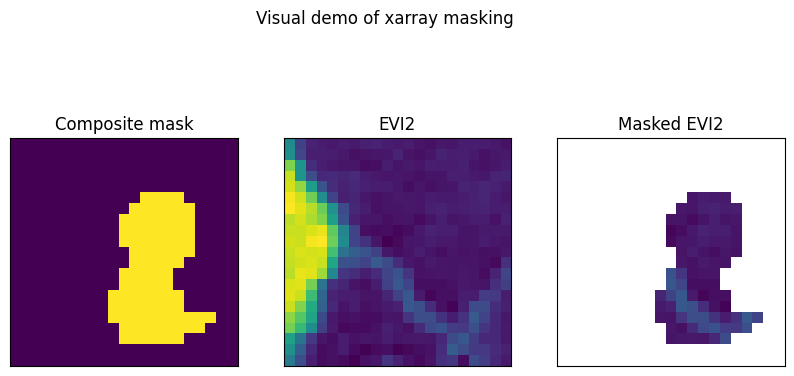

In [152]:
# Used chained where condition

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

ax = axs[0]
ax.imshow(xr.where(cereal_mask, xr.where(good_scl_masks_xr, 1, 0), 0).isel(time=0))
ax.set_title('Composite mask')

ax = axs[1]
ax.imshow(evi2_xr.isel(time=0))
ax.set_title('EVI2')

ax = axs[2]
ax.imshow(xr.where(cereal_mask, 
                      xr.where(good_scl_masks_xr, 
                               evi2_xr, 
                               np.nan), 
             np.nan).isel(time=0), interpolation=None, vmin=evi2_xr.isel(time=0).min(), vmax=evi2_xr.isel(time=0).max())
ax.set_title('Masked EVI2')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.suptitle("Visual demo of xarray masking")


Calculate imagery-derived phenology and productivity parameters for the demo datapoint.

As per https://github.com/lewistrotter/PhenoloPy/blob/main/Phenolopy.ipynb

Note that I've made a few minor fixes in my local version of the phenolopy module to make the functions play nicely with new xarray and numpy releases.

In [153]:
# Mask the EVI2 dataset
evi2_cereal_xr = xr.where(cereal_mask, 
                                  xr.where(good_scl_masks_xr, 
                                           evi2_xr, 
                                           np.nan), 
                          np.nan)

# Just do a bit of xarray preparation
evi2_cereal_xr = evi2_cereal_xr.drop_vars('band')
evi2_cereal_xr = evi2_cereal_xr.assign_coords({'spatial_ref': int(''.join([i for i in WORKING_CRS if i.isdigit()]))})

# Redefine as a dataset
evi2_cereal_xr = xr.Dataset({'veg_index': evi2_cereal_xr})
evi2_cereal_xr = evi2_cereal_xr.assign_attrs({'crs': WORKING_CRS, 'grid_mapping': 'spatial_ref'})

In [154]:
evi2_cereal_xr = phenolopy.group(evi2_cereal_xr)

Group dataset interval: month via reducer: median
> Selecting year: 2019 to re-label times after groupby.
> Warning: dataset contains nan values. You should interpolate nan values next.
> Group successful.



In [155]:
evi2_cereal_xr = phenolopy.remove_outliers(ds=evi2_cereal_xr, method='median', user_factor=2)

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.



In [156]:
# set resample interval now, as a few functions require it
interval = '2W'

evi2_cereal_xr = phenolopy.correct_last_datetime(evi2_cereal_xr, interval)
evi2_cereal_xr = phenolopy.resample(evi2_cereal_xr, interval=interval, reducer='median')

Correcting last datetime value to ensure adequate resampling output.
> Changing day of last datetime value in dataset to the 31st.
> Corrected late datetime value successfully.
Resampling dataset interval: 2W via reducer: median
> Warning: dataset contains nan values. You should interpolate nan values next.
> Resample successful.



In [157]:
evi2_cereal_xr = phenolopy.interpolate(ds=evi2_cereal_xr, method='interpolate_na')
evi2_cereal_xr = phenolopy.remove_non_dominant_year(evi2_cereal_xr)


Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Checking and removing non-dominant year often introduced following resampling.
> More than one year detected in dataset. Removal non-dominant years.
> Checked and removed non-dominant year (if needed) successfully.


In [158]:
evi2_cereal_xr = phenolopy.smooth(ds=evi2_cereal_xr, method='savitsky', window_length=3, polyorder=1)

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



In [159]:
result = phenolopy.calc_phenometrics(evi2_cereal_xr['veg_index'], 
                                     peak_metric='pos', 
                                     base_metric='bse_fifth_per', 
                                     method='first_of_slope', 
                                     factor=0.5, 
                                     thresh_sides='two_sided', 
                                     abs_value=0)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of fifth percentile veg index (bse_fifth_per) values.
> Calculating fifth percentile veg index (bse_fifth_per) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning addition of CRS metadata.
> Adding CRS metadata.
> Could not add CRS metadata to data. Aborting.

Phenometrics calculated successfully!


Amplitude (aos) of the vegetation index id defined as the peak value (max observed in the season) minus the base value (fifth percentile of veg index) and was found to have the strongest correlation with farmer reported yields, alongside peak EVI2 ###CITE.

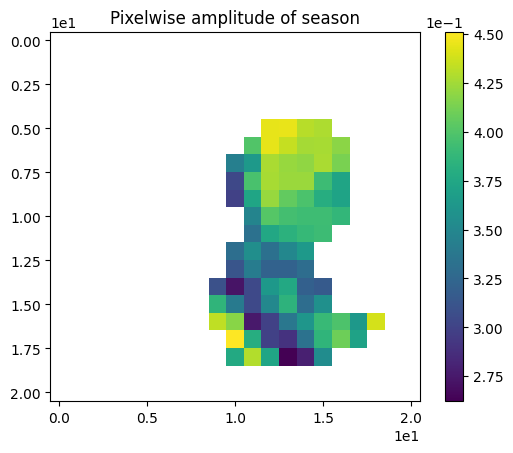

In [160]:
plt.figure()
plt.imshow(result.isel(phen_metric=2).to_numpy())
plt.colorbar()
# plt.title(result.isel(phen_metric=metric)['phen_metric'].to_numpy().__str__())
plt.title('Pixelwise amplitude of season')
plt.show()

Now plot the pixel-wise EVI2 time series, as well as the amplitude metric distribution for pixels labelled spring cereals according to CROME.

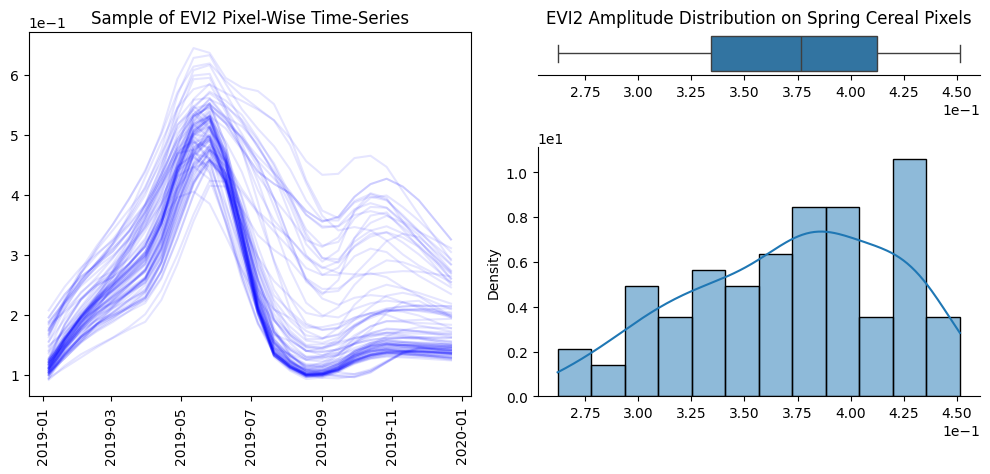

In [161]:
non_null_mask = ~evi2_cereal_xr.isnull().all('time')['veg_index'].to_numpy() # All nan slices
veg_index_timeseries = np.stack([evi2_cereal_xr.isel(time=i)['veg_index'].to_numpy()[non_null_mask] for i in range(evi2_cereal_xr.dims['time'])])
aos_vals = result.sel(phen_metric='aos_values').to_numpy()[non_null_mask]

# Create 2x2 sub plots
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=(.15, .85))

plt.figure(figsize=(10, 5))

ax = plt.subplot(gs[:, 0]) 
for pixel_ref in range(0, veg_index_timeseries.shape[1]):
    ax.plot(evi2_cereal_xr.time, veg_index_timeseries[:, pixel_ref], color='b', alpha=0.1)
ax.set_title('Sample of EVI2 Pixel-Wise Time-Series')
ax.tick_params(axis='x', labelrotation=90)

_ax = plt.subplot(gs[0, 1]) # row 0, col 1
sns.boxplot(x=aos_vals, ax=_ax)
_ax.set(yticks=[])
sns.despine(ax=_ax, left=True)
_ax.set_title('EVI2 Amplitude Distribution on Spring Cereal Pixels')

ax = plt.subplot(gs[1, 1]) 
ax.sharex(_ax)
sns.histplot(x=aos_vals, bins=12, kde=True, stat='density', ax=ax)
sns.despine(ax=ax)


plt.tight_layout()
plt.show()



#### Loop over full imagery dataset

In [162]:
def get_aos(aoi_dir):
    '''Returns the median evi2 amplitude on spring cereal fields in AOI'''

    
    distributed_print(f'Beginning processing for {aoi_dir}')

    # Get static mask (independent of time)
    cereal_mask = get_cereal_masks(aoi_dir) & get_study_area_mask(aoi_dir) & get_scl_never_veg_mask(aoi_dir)

    # Define relevant Xarray variables
    evi2_paths = sorted(glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif')))
    dates_xr = xr.Variable('time', pd.to_datetime([i.split('/')[-2] for i in evi2_paths], format='%Y_%m_%d'))
    evi2_xr = xr.concat([rioxarray.open_rasterio(path) for path in evi2_paths], dim=dates_xr).squeeze()
    
    # Create masks (date-specific) based on SCL good pixels
    good_scl_masks_xr = xr.DataArray(np.stack([get_scl_good_mask(aoi_dir, date) for date in dates_xr.to_index().strftime('%Y_%m_%d')]),
                                     coords=evi2_xr.coords,
                                      dims=('time', 'y', 'x'))




    # Mask the EVI2 dataset
    evi2_cereal_xr = xr.where(cereal_mask, 
                                      xr.where(good_scl_masks_xr, 
                                               evi2_xr, 
                                               np.nan), 
                              np.nan)

    # Now for the phenology and productivity calculations
    # Just do a bit of xarray preparation
    evi2_cereal_xr = evi2_cereal_xr.drop_vars('band')
    evi2_cereal_xr = evi2_cereal_xr.assign_coords({'spatial_ref': int(''.join([i for i in WORKING_CRS if i.isdigit()]))})
    evi2_cereal_xr = xr.Dataset({'veg_index': evi2_cereal_xr})
    evi2_cereal_xr = evi2_cereal_xr.assign_attrs({'crs': WORKING_CRS, 'grid_mapping': 'spatial_ref'})
    evi2_cereal_xr = phenolopy.group(evi2_cereal_xr)
    evi2_cereal_xr = phenolopy.remove_outliers(ds=evi2_cereal_xr, method='median', user_factor=2, z_pval=0.05)
    interval = '2W'
    evi2_cereal_xr = phenolopy.correct_last_datetime(evi2_cereal_xr, interval)
    evi2_cereal_xr = phenolopy.resample(evi2_cereal_xr, interval=interval, reducer='median')
    evi2_cereal_xr = phenolopy.interpolate(ds=evi2_cereal_xr, method='interpolate_na')
    evi2_cereal_xr = phenolopy.remove_non_dominant_year(evi2_cereal_xr)
    evi2_cereal_xr = phenolopy.smooth(ds=evi2_cereal_xr, method='savitsky', window_length=3, polyorder=1)

    result = phenolopy.calc_phenometrics(evi2_cereal_xr['veg_index'], 
                                     peak_metric='pos', 
                                     base_metric='bse_fifth_per', 
                                     method='first_of_slope', 
                                     factor=0.5, 
                                     thresh_sides='two_sided', 
                                     abs_value=0)

    non_null_mask = ~evi2_cereal_xr.isnull().all('time')['veg_index'].to_numpy() # All nan slices
    veg_index_timeseries = np.stack([evi2_cereal_xr.isel(time=i)['veg_index'].to_numpy()[non_null_mask] for i in range(evi2_cereal_xr.dims['time'])])
    aos_vals = result.sel(phen_metric='aos_values').to_numpy()[non_null_mask]

    distributed_print(f'Done processing {aoi_dir}')

    return aoi_dir, np.median(aos_vals)



In [163]:

results = []
aoi_dirs = [i for i in os.listdir(DATA_BASE_PATH) if (i != 'aos_results.csv') and ('metadata.csv' in os.listdir(os.path.join(DATA_BASE_PATH, i)))]
for aoi_dir in aoi_dirs:
    results.append(get_aos(aoi_dir))

results = pd.DataFrame(results, columns=['location', 'median_aos']).dropna()
results.to_csv(os.path.join(DATA_BASE_PATH, 'aos_results.csv'))

Beginning processing for location_6276882_2019
Group dataset interval: month via reducer: median
> Selecting year: 2019 to re-label times after groupby.
> Warning: dataset contains nan values. You should interpolate nan values next.
> Group successful.

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Correcting last datetime value to ensure adequate resampling output.
> Changing day of last datetime value in dataset to the 31st.
> Corrected late datetime value successfully.
Resampling dataset interval: 2W via reducer: median
> Warning: dataset contains nan values. You should interpolate nan values next.
> Resample successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Checking an

## Results

In [164]:
results = pd.read_csv(os.path.join(DATA_BASE_PATH, 'aos_results.csv'), index_col=0)
results['sample_id'] = results['location'].str.split('_').str[1].astype('Int64')
results = results.drop(columns='location')
results = results.merge(sample_info[['survey_id']], how='left', left_on='sample_id', right_index=True)
results.head()



,median_aos,sample_id,survey_id
0,0.302184,6276882,155
1,0.320410,8148381,155
2,0.265604,10530878,87
3,0.420162,3536063,155
4,0.690783,14727289,87


In [165]:
results = results.merge(occurrences, 
                         how='left', 
                         on='sample_id')

# Domin scale Range (%) Mid-range value (%)
# Based on https://www.researchgate.net/publication/273759339_Irish_semi-natural_grasslands_survey_2007-2012/citation/download

domin_map = {'10'    : 96,
             '9'     : 83,
             '8'     : 63,
             '7'     : 42,
             '6'     : 30,
             '5'     : 18,
             '4'     : 8,
             '3'     : 3,
             '2'     : 0.5,
             '1'     : 0.3,
             np.nan: 0.1}

results['perc_cover'] = results['domin'].str.split('.').str[0].map(lambda x: domin_map.get(x)) / 100
cover_totals  = results.groupby('sample_id')[['perc_cover']].sum().rename(columns={'perc_cover': 'cover_total'})
results = results.merge(cover_totals, left_on='sample_id', right_index=True)
results['rel_cover'] = results['perc_cover'] / results['cover_total']

results.head()

,median_aos,sample_id,survey_id,taxonversionkey,preferred_taxon,domin,perc_cover,cover_total,rel_cover
0,0.302184,6276882,155,NBNSYS0000004492,Cirsium arvense,2. < 1% (several indivs),0.005,0.048,0.104167
1,0.302184,6276882,155,NBNSYS0000004319,Galium aparine,2. < 1% (several indivs),0.005,0.048,0.104167
2,0.302184,6276882,155,NBNSYS0000003222,Medicago lupulina,3. 1-4%,0.030,0.048,0.625000
3,0.302184,6276882,155,NBNSYS0000003807,Urtica dioica,2. < 1% (several indivs),0.005,0.048,0.104167
4,0.302184,6276882,155,NBNSYS0000004542,Sonchus arvensis,1. < 1% (1-2 indivs),0.003,0.048,0.062500


In [166]:
results.dropna(inplace=True)

### Species abundance

In [167]:
grouped_results = results.groupby(['survey_id', 'sample_id', 'median_aos'])[['preferred_taxon']].nunique().reset_index()
grouped_results['color'] = pd.factorize(grouped_results['survey_id'])[0] / 2
grouped_results

,survey_id,sample_id,median_aos,preferred_taxon,color
0,87,3508410,0.454668,17,0.0
1,87,3599861,0.463938,4,0.0
2,87,4580076,0.296884,1,0.0
3,87,5352044,0.582884,1,0.0
4,87,6699577,0.504379,9,0.0
5,87,6973465,0.472015,6,0.0
6,87,10095531,0.567370,2,0.0
7,87,10530828,0.425264,7,0.0
8,87,10530878,0.265604,4,0.0
9,87,12533723,0.292259,6,0.0


<Axes: xlabel='median_aos', ylabel='preferred_taxon'>

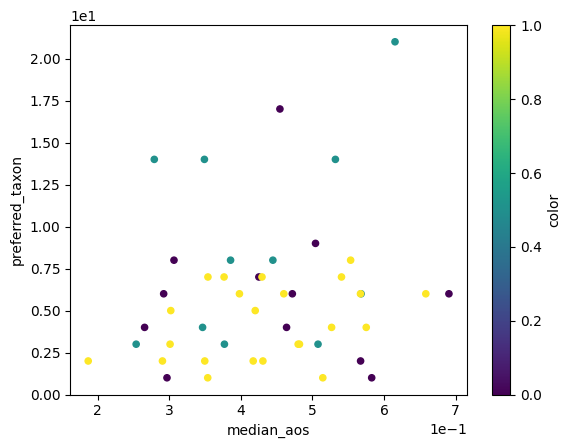

In [168]:
grouped_results.plot.scatter('median_aos', 'preferred_taxon', c='color')

In [169]:
grouped_results.groupby('survey_id').apply(lambda group: pearsonr(group['median_aos'], group['preferred_taxon']))

survey_id
87     (-0.02043498731842584, 0.9497387631589433)
154     (0.35001847528743163, 0.2913212529853433)
155    (0.35664916579984496, 0.09482064124452992)
dtype: object

### Shannon diversity

Use relative cover computed per sample as in CITE MAIN### to estimate shannon diversity.

In [170]:
def shannon(sample_rel_covers):
    shannon = -np.sum(np.multiply(sample_rel_covers, np.log(sample_rel_covers)))

    return shannon

<Axes: xlabel='median_aos', ylabel='shannon_index'>

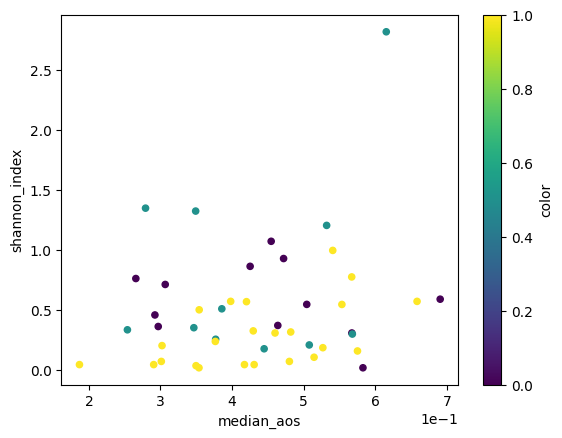

In [171]:
grouped_results = results.groupby(['survey_id', 'sample_id', 'median_aos'])[['perc_cover']].apply(shannon).reset_index().rename(columns={'perc_cover': 'shannon_index'})
grouped_results['color'] = pd.factorize(grouped_results['survey_id'])[0] / 2
grouped_results.plot.scatter('median_aos', 'shannon_index', c='color')

In [172]:
grouped_results.groupby('survey_id').apply(lambda group: pearsonr(group['median_aos'], group['shannon_index']))

survey_id
87      (-0.2398861459537346, 0.4526683370403348)
154       (0.3382964357728551, 0.308875928586615)
155    (0.5053360954222429, 0.013905905071547365)
dtype: object

<Axes: xlabel='median_aos', ylabel='shannon_index'>

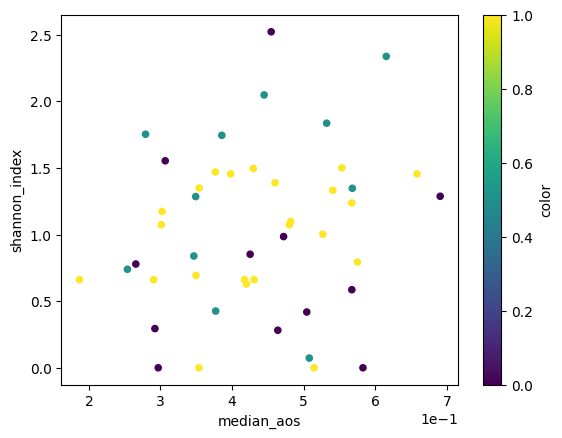

In [173]:
grouped_results = results.groupby(['survey_id', 'sample_id', 'median_aos'])[['rel_cover']].apply(shannon).reset_index().rename(columns={'rel_cover': 'shannon_index'})
grouped_results['color'] = pd.factorize(grouped_results['survey_id'])[0] / 2
grouped_results.plot.scatter('median_aos', 'shannon_index', c='color')

In [174]:
grouped_results.groupby('survey_id').apply(lambda group: pearsonr(group['median_aos'], group['shannon_index']))

survey_id
87      (0.06253997009983278, 0.8468928465992565)
154    (0.31271824250680574, 0.34911166236045077)
155      (0.2573374606971803, 0.2358524438138362)
dtype: object

## Discussion and conclusions

## References